In [112]:
import arch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from datetime import date, timedelta
from statsmodels.tsa.stattools import adfuller

from algo.cointegration.augmented_dickey_fuller import adf_stationarity
from algo.forecasting.arima_multiprocessing import arima_parallel


sns.set_style("darkgrid")

In [113]:
# Data
end_date = date.today()
start_date = "2021-01-01"
interval = "1d"
ticker = "CL=F"

df = yf.download(ticker, start=start_date, end=end_date.strftime("%Y-%m-%d"), interval=interval)
df = df[["Adj Close"]].rename(columns={"Adj Close": "price"})
df.tail()

[*********************100%***********************]  1 of 1 completed


,price
Date,
2023-02-17,76.339996
2023-02-21,76.160004
2023-02-22,73.949997
2023-02-23,75.389999
2023-02-24,76.320000


In [114]:
# Test for Stationarity - ADF Test.
is_stationary = adf_stationarity(df["price"], trend="c")
print(f"price stationary = {is_stationary}")

# Perform differencing until stationary.
periods = 1
df[f"price_diff_{periods}"] = df["price"].diff(periods=periods)
df.dropna(inplace=True)

is_stationary = adf_stationarity(df["price_diff_1"], trend="c")
print(f"price diff 1 stationary = {is_stationary}")

price stationary = False
price diff 1 stationary = True


In [115]:
# Number of lags to trial.
lags = 25

conf_interval = {95: 0.05}
alpha = conf_interval[95]

acf, conf = sm.tsa.stattools.acf(x=df["price"], nlags=lags, alpha=alpha)

# Centre the confidence boundaries on the data.
conf_centred = conf - np.expand_dims(acf, axis=-1)

# Significant data: outside of the blue bands (above or below).
sig_data = np.abs(acf) >= conf_centred[:, 1]

# Largest lag of raw (non-differenced) price data.
max_lag = max(index for index, value in enumerate(sig_data) if value)
max_lag

25

/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


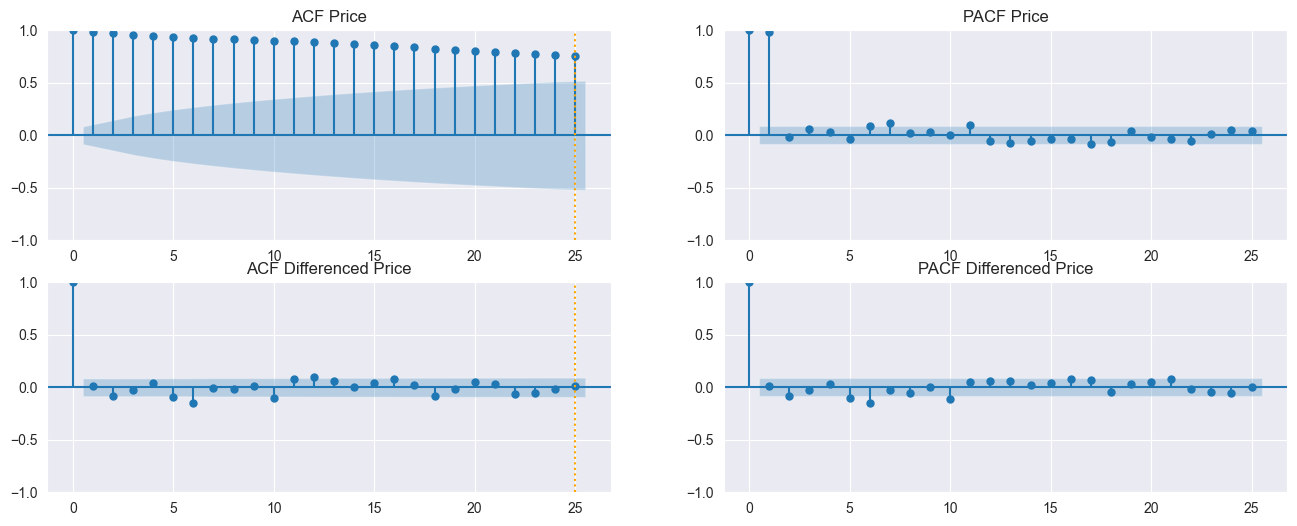

In [116]:
# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price"]

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Price")

ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF Price")

# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price_diff_1"]

ax3 = fig.add_subplot(223)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax3)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Differenced Price")

ax4 = fig.add_subplot(224)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax4)
plt.title("PACF Differenced Price")

plt.show()

In [117]:
# EXTEND
max_lag = 6

p_candidates = range(max_lag)
d_candidates = (0,)
q_candidates = range(max_lag)

models = arima_parallel(
    p_candidates,
    d_candidates,
    q_candidates,
    data=df["price_diff_1"].values,
    num_processes=8,
)

In [118]:
p_opt, q_opt = min(models, key=models.get)
d = 0
print(p_opt, q_opt)

# Fit the final model (not storing candidate model objects).
arima_model = sm.tsa.arima.ARIMA(endog=x, order=(p_opt, d, q_opt)).fit()

5 5


/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'PACF for squared ARMA residuals')

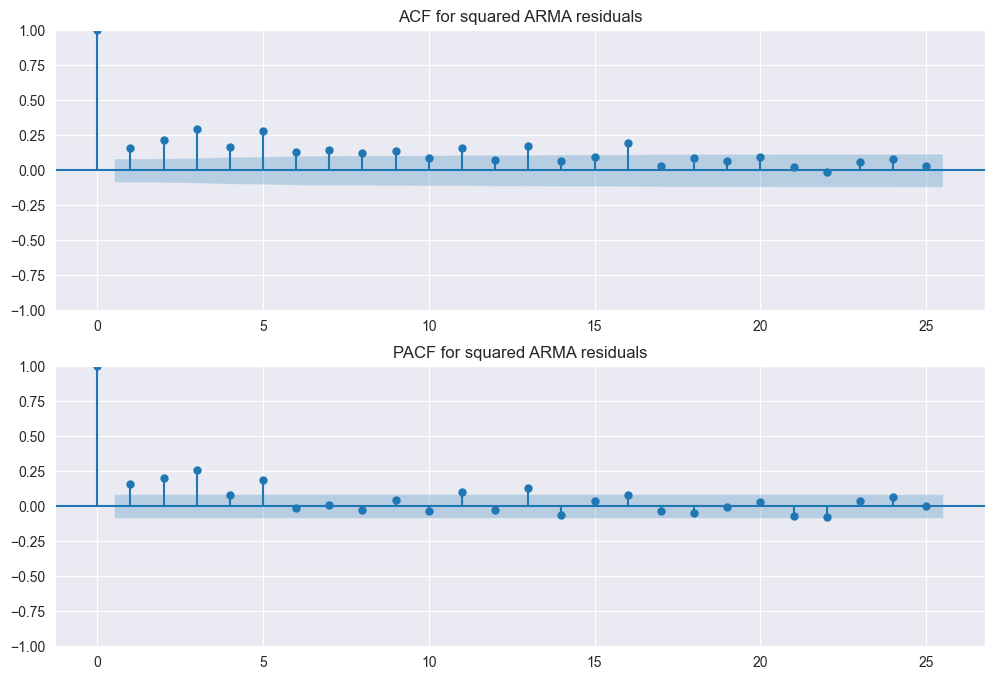

In [119]:
# Use PACF to assess order of ARCH model.
x = np.square(arima_model.resid)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.title("ACF for squared ARMA residuals")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF for squared ARMA residuals")

/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'PACF for squared differenced prices')

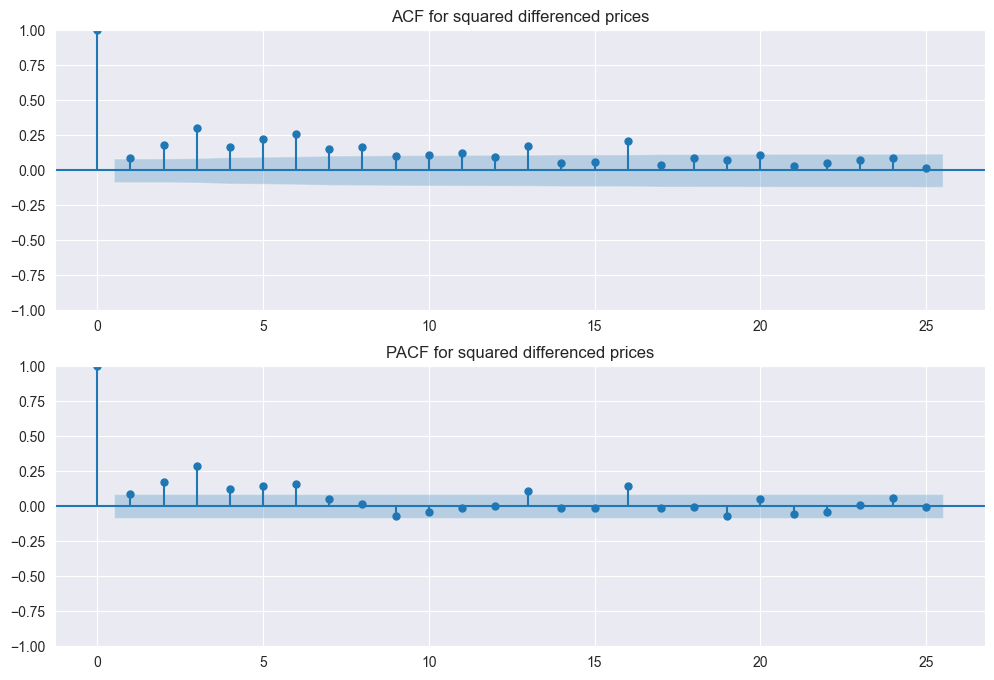

In [120]:
df["price_diff_1_sq"] = np.square(df["price_diff_1"])
x = df["price_diff_1_sq"]

# Use PACF to assess serial autocorrelation in squared differenced series..
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.title("ACF for squared differenced prices")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF for squared differenced prices")

In [121]:
%%capture arch_capture
# Capture verbose logs from arch package. (Magic command must preceed this comment).


# Reduce num lags to search over cf. plots above.
lags = 6
performance = {}

# GARCH(P, Q) - note cannot have P=0 && o=0.
o = 0
for P, Q in itertools.product(range(lags)[1:], range(lags)):
    # Fit GARCH(P,Q) model to the differenced price series for (P,Q) candidates.
    garch_model = arch.arch_model(df["price_diff_1"].values, vol="garch", p=P, o=0, q=Q).fit()
    performance[(P, Q)] = garch_model.aic
    
# Find the (p, q) corresponding to the minimum AIC.
P_opt, Q_opt = min(performance, key=performance.get)
print(P_opt, Q_opt)

In [122]:
df.shape

(542, 3)

In [123]:
# num_train_initial = 600
num_train_initial = 400
# num_train_initial = 252

start_test_index = num_train_initial + 1
print(f"Start Test: {start_test_index}")

df["day"] = df.index.day_name()

# Move the start of the test to the nearest Monday after enough data is used for initial training.
# while df.loc[df.index[start_test_index]].day_of_week != 0.0:
while df.loc[df.index[start_test_index]].day != "Monday":
    start_test_index +=1
    
    if start_test_index > len(df):
        # Fail safe.
        break

print(f"Start Test Adj: {start_test_index}")

Start Test: 401
Start Test Adj: 402


In [144]:
%%capture arch_capture


train_df = df.head(num_train_initial).copy()
test_df = df.tail(len(df) - num_train_initial).copy()

test_group = test_df.groupby(by=[test_df.index.isocalendar().year, test_df.index.isocalendar().week])


arima_params = {}
garch_params = {}

# TODO: increase this.
lags = 2
num_processes = lags

# Walk forward predictions.
for index, (yr_wk, test_data) in enumerate(test_group):
    # Train ARIMA-GARCH on all train data.
    # train_data = train_df["price_diff_1"].values

    p_candidates = range(lags)
    d_candidates = (0,)
    q_candidates = range(lags)

    # Fit ARIMA Model to conditional mean function.
    arima_models = arima_parallel(
        p_candidates,
        d_candidates,
        q_candidates,
        data=train_data,
        num_processes=num_processes,
    )
    p_opt, q_opt = min(models, key=models.get)
    arima_params[index] = (p_opt, q_opt)
    
    arima_model = sm.tsa.arima.ARIMA(endog=train_df["price_diff_1"].values, order=(p_opt, 0, q_opt)).fit()
    
    ######
    
    # Fit GARCH Model to conditional variance Function.
    performance = {}
    o = 0
    # Cannot have P=0 && o=0.
    for P, Q in itertools.product(range(lags)[1:], range(lags)):
        # Fit GARCH(P,Q) model to the differenced price series for (P,Q) candidates.
        # garch_model = arch.arch_model(df["price_diff_1"].values, vol="garch", p=P, o=0, q=Q).fit()
        garch_model = arch.arch_model(arima_model.resid, vol="garch", p=P, o=0, q=Q).fit()
        performance[(P, Q)] = garch_model.aic

    # Find the (p, q) corresponding to the minimum AIC.
    P_opt, Q_opt = min(performance, key=performance.get)
    garch_params[index] = (P_opt, Q_opt)
    
    garch_model = arch.arch_model(arima_model.resid, vol="garch", p=P_opt, o=0, q=Q_opt).fit()
    
    ######
    
    # Predict mean and variance functions on current test set.
    num_test = len(test_data)
    arima_preds = arima_model.forecast(steps=num_test)
    garch_preds = garch_model.forecast(horizon=num_test, reindex=False).mean.values[0]
    
    
    ######
    
    # Log Results.
    # For now.
    start_pred_index = test_data.index[0]
    end_pred_index = test_data.index[-1]
    df.loc[start_pred_index : end_pred_index, "arima_preds_diff_1"] = arima_preds
    df.loc[start_pred_index : end_pred_index, "garch_preds_diff_1"] = garch_preds
    
    # Undo differencing.
    df.loc[start_pred_index : end_pred_index, "arima_preds"] = train_df.loc[train_df.index[-1], "price"] + arima_preds.cumsum()
    
    # Future: maybe separate out to different columns.
    # df.loc[df.index[start_pred_index], f"pred_{index}"]    
    
    # Join current test set with train set.
    train_df = pd.concat([train_df, test_data])

In [145]:
df

,price,price_diff_1,price_diff_1_sq,day,arima_preds,garch_preds,arima_preds_diff_1,garch_preds_diff_1
Date,,,,,,,,
2021-01-05,49.930000,2.310001,5.336106,Tuesday,NaN,NaN,NaN,NaN
2021-01-06,50.630001,0.700001,0.490001,Wednesday,NaN,NaN,NaN,NaN
2021-01-07,50.830002,0.200001,0.040000,Thursday,NaN,NaN,NaN,NaN
2021-01-08,52.240002,1.410000,1.988100,Friday,NaN,NaN,NaN,NaN
2021-01-11,52.250000,0.009998,0.000100,Monday,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-02-17,76.339996,-2.150002,4.622507,Friday,77.950209,0.116163,-0.509428,0.116163
2023-02-21,76.160004,-0.179993,0.032397,Tuesday,75.478664,0.134496,-0.861332,0.134496
2023-02-22,73.949997,-2.210007,4.884130,Wednesday,75.267096,0.134496,-0.211568,0.134496


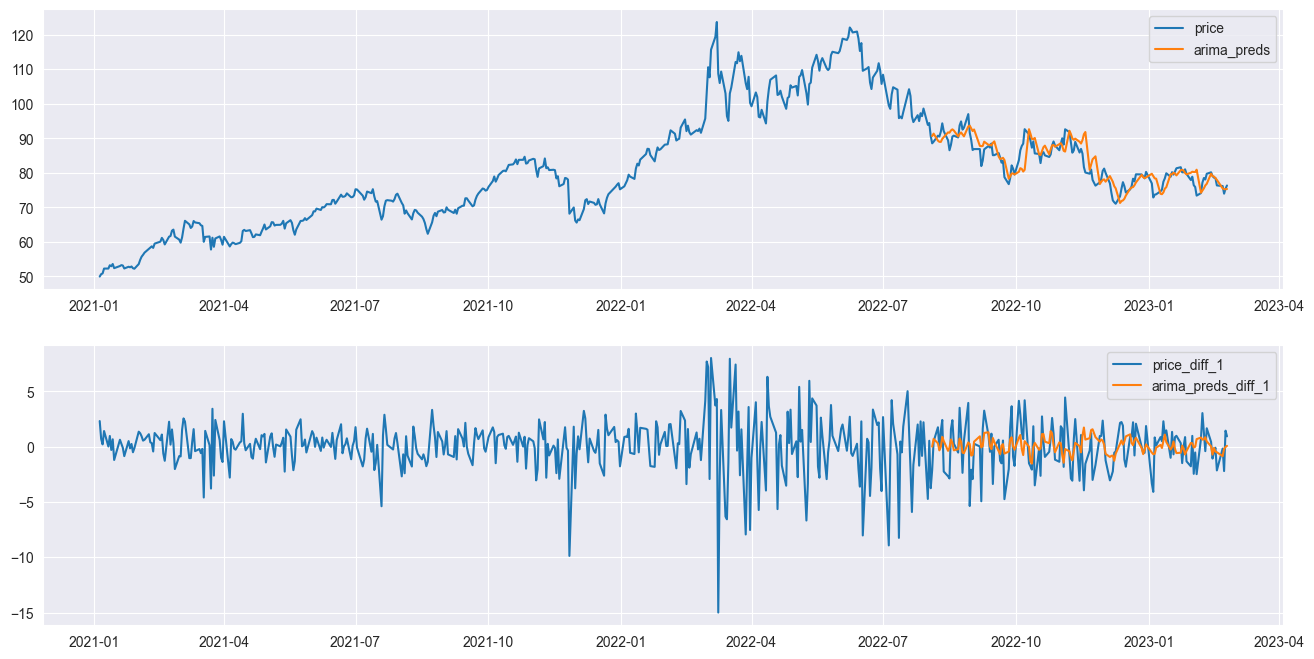

In [161]:
fig = plt.figure()
fig.set_size_inches(16, 8)

plt.subplot(2, 1, 1)
plt.plot(df["price"], label="price")
plt.plot(df["arima_preds"], label="arima_preds")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df["price_diff_1"], label="price_diff_1")
plt.plot(df["arima_preds_diff_1"], label="arima_preds_diff_1")
plt.legend()

plt.show()

In [ ]:
# TODO:
# 1. Add below to above.
# 2. Refactor to train and pred functions.
# 3. See bottom cell - GARCH conf. int..
# 4. Parallelise GARCH.


"""
When:

# Garch underlying price diff.
garch_model = arch.arch_model(df["price_diff_1"].values, vol="garch", p=P_opt, o=0, Q_opt=Q).fit()

vs. ARIMA resid.
"""

In [ ]:
%%capture arch_capture
# Capture verbose logs from arch package. (Magic command must preceed this comment).


# Methodology 1: use ARIMA to compute the conditional mean at time t. Remember this is on the differenced series.
predicted_mean_t = arima_model.forecast(steps=1)

# Methodology 2: use GARCH to compute the conditional variance of the residuals of the ARIMA model.
garch_model = arch.arch_model(arima_model.resid, vol="garch", p=P_opt, o=0, q=Q_opt).fit()

# Methodology 3: 1-step OOS forecast.
garch_forecast = garch_model.forecast(horizon=1, reindex=False)

# GARCH predicted error at time t: `epsilon_t`.
predicted_error_t = garch_forecast.mean["h.1"].iloc[-1]

# Methodology 4: combine ARIMA + GARCH model outputs, using: y_hat_t = mu_t + epsilon_t
prediction = predicted_mean_t + predicted_error_t

print(f"ARIMA predicted mean = {predicted_mean_t}")
print(f"GARCH predicted error = {predicted_error_t}")
print(f"ARIMA-GARCH prediction = {prediction}")

In [ ]:
# Inferred variances are conditioned on standard normal errror. Run many predictions and take an average.
num_trials = 1000
predicted_error_t_mean = np.mean([np.random.normal(loc=0.0, scale=1.0) * predicted_error_t for _ in range(num_trials)])

# ARIMA Model predicts the conditional mean for the DIFFERENCED series.
# "Undo" this by adding the prediction of the next difference to the current price.
price_tp1 = df["price"].iloc[-1] + predicted_mean_t + predicted_error_t_mean


print(f"ARIMA-GARCH next price prediction = {price_tp1}")

# Confidence Intervals

In [ ]:
arima_model.conf_int()

In [ ]:
garch_model.conf_int()

In [ ]:
%%capture arch_capture


# For simplicitly, allow some data creep - i.e. the values of (p,q,P,Q) were optimised on the entire dataset.
rolling_predictions = []
conf_lb = []
conf_ub = []
test_size = 10
for i in range(test_size):
    train = df["price_diff_1"][:-(test_size-i)]
    garch_model = arch.arch_model(train, p=1, q=1).fit(disp="off")
    pred = garch_model.forecast(horizon=1)
    conf = garch_model.conf_int() 
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    conf_lb.append(conf.loc["mu", "lower"])
    conf_ub.append(conf.loc["mu", "upper"])    

In [ ]:
rolling_predictions = pd.Series(rolling_predictions, index=df["price_diff_1"].index[-test_size:])
rolling_predictions = pd.Series(conf_lb, index=df["price_diff_1"].index[-test_size:])
rolling_predictions = pd.Series(conf_ub, index=df["price_diff_1"].index[-test_size:])
# fig, ax = plt.subplots(figsize=(10,4))
plt.plot(rolling_predictions)
plt.plot(conf_lb)
plt.plot(conf_ub)
plt.title("Rolling Prediction")

In [ ]:
# Methodology 2: use GARCH to compute the conditional variance of the residuals of the ARIMA model.
garch_model = arch.arch_model(arima_model.resid, vol="garch", p=P_opt, o=0, q=Q_opt).fit()

In [ ]:
# Methodology 3: 1-step OOS forecast.
garch_forecast = garch_model.forecast(horizon=1, reindex=False)

In [ ]:
garch_forecast.p